In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Activation

import tensorboard

In [2]:
directory = 'datathon 2022 dataset'
# ims = 256
image_size = (222,294)
# Generates a tf.data.Dataset from image files in a directory.
df = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size = image_size,
    shuffle=True,
    seed=2,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    crop_to_aspect_ratio=False,
)

Found 2985 files belonging to 5 classes.


In [3]:
class_names = df.class_names
print(class_names)

['Acne', 'Cyst, tumour and skin-tags', 'Melanoma', 'Moneypox', 'Normal skin']


In [4]:
# plt.figure(figsize=(10, 10))
# for images, labels in df.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")


In [5]:
# print(len(df))

In [6]:
# tf.take(10) will take 10 image sets from the dataset
# tf.skip(10) will skip 10 image sets from the dataset
# doen't need to shuffle the dataset as it is already shuffled

train_ds = df.take(64)
test_ds = df.skip(64)

val_ds = test_ds.take(20)
test_ds = test_ds.skip(20)

In [7]:
# print(len(df), len(train_ds), len(val_ds), len(test_ds))

In [8]:
# cache the dataset in the memory to improve performance
# prefetch the dataset to improve performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
data_augmentation = Sequential([
  layers.RandomFlip('horizontal_and_vertical'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
])

In [10]:
# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [11]:
# remving the classification layer by include_top=False
IMG_SHAPE = image_size + (3,)
base_model = keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')  # weights='imagenet' loads the weights pre-trained on ImageNet.

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 470

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


In [13]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(254, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax'),
])
model.build(input_shape=(None, image_size[0], image_size[1], 3))

In [14]:
# model.summary()

In [15]:
model.compile(optimizer=keras.optimizers.SGD(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
class_weights = {0: (700/400),
                 1: (700/600),
                 2: (700/600),
                 3: 1.,
                 4: 1.}

In [17]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[callback],class_weight=class_weights)

Epoch 1/10
64/64 [==============================] - 119s 1s/step - loss: 1.6843 - accuracy: 0.4111 - val_loss: 1.1850 - val_accuracy: 0.6938
Epoch 2/10
64/64 [==============================] - 67s 1s/step - loss: 1.2892 - accuracy: 0.6475 - val_loss: 0.8990 - val_accuracy: 0.7484
Epoch 3/10
64/64 [==============================] - 68s 1s/step - loss: 1.0249 - accuracy: 0.7148 - val_loss: 0.7272 - val_accuracy: 0.7797
Epoch 4/10
64/64 [==============================] - 58s 903ms/step - loss: 0.8832 - accuracy: 0.7383 - val_loss: 0.6223 - val_accuracy: 0.8000
Epoch 5/10
64/64 [==============================] - 54s 839ms/step - loss: 0.7726 - accuracy: 0.7627 - val_loss: 0.5496 - val_accuracy: 0.8109
Epoch 6/10
64/64 [==============================] - 55s 858ms/step - loss: 0.7008 - accuracy: 0.7915 - val_loss: 0.4987 - val_accuracy: 0.8359
Epoch 7/10
64/64 [==============================] - 53s 835ms/step - loss: 0.6295 - accuracy: 0.7983 - val_loss: 0.4620 - val_accuracy: 0.8516
Epoch 8

In [18]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

10/10 [==============================] - 9s 187ms/step - loss: 0.3886 - accuracy: 0.8788
Test accuracy : 0.8787878751754761


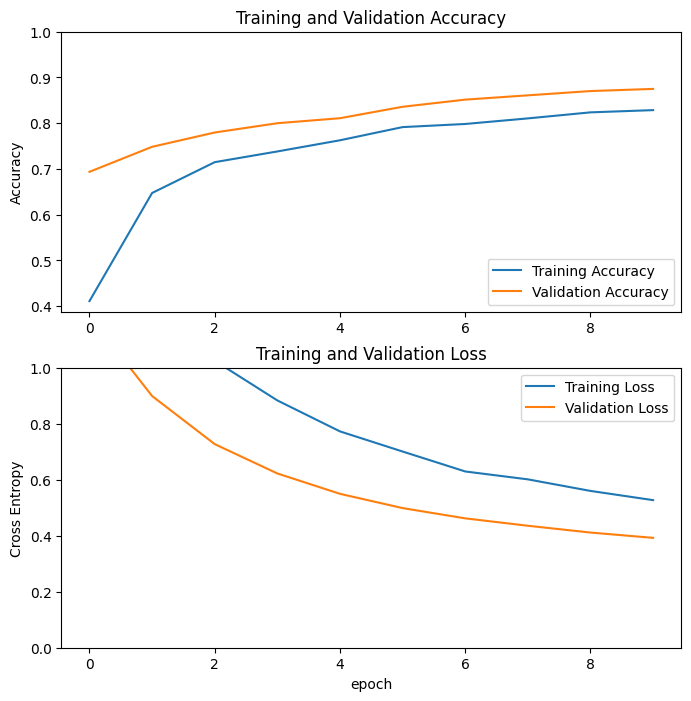

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
acne_test_ds = test_ds.unbatch().filter(lambda image, label: label == 0).batch(32)
cyst_test_ds = test_ds.unbatch().filter(lambda image, label: label == 1).batch(32)
melanoma_test_ds = test_ds.unbatch().filter(lambda image, label: label == 2).batch(32)
moneypox_test_ds = test_ds.unbatch().filter(lambda image, label: label == 3).batch(32)
normal_test_ds = test_ds.unbatch().filter(lambda image, label: label == 4).batch(32)


a_loss, a_accuracy = model.evaluate(acne_test_ds)
c_loss, c_accuracy = model.evaluate(cyst_test_ds)
me_loss, me_accuracy = model.evaluate(melanoma_test_ds)
mo_loss, mo_accuracy = model.evaluate(moneypox_test_ds)
n_loss, n_accuracy = model.evaluate(normal_test_ds)

print('Acne Test accuracy :', a_accuracy)
print('Cyst Test accuracy :', c_accuracy)
print('Melanoma Test accuracy :', me_accuracy)
print('Moneypox Test accuracy :', mo_accuracy)
print('Normal Test accuracy :', n_accuracy)

3/3 [==============================] - 1s 162ms/step - loss: 0.3074 - accuracy: 0.9041
Acne Test accuracy : 0.84375
Cyst Test accuracy : 0.800000011920929
Melanoma Test accuracy : 0.9642857313156128
Moneypox Test accuracy : 0.8684210777282715
Normal Test accuracy : 0.9041095972061157


In [21]:
import numpy as np
from sklearn.metrics import classification_report


static_train_ds = tf.data.Dataset.from_tensors(train_ds)
for element in static_train_ds:
    static_train_ds = element

test_labels = np.array([])
for image_batch, label_batch in static_train_ds:
    test_labels = np.concatenate((test_labels, label_batch.numpy()), axis=0)

# classfiaction report

y_pred = model.predict(static_train_ds)
y_pred = np.argmax(y_pred, axis=1)

print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=class_names))

64/64 [==============================] - 15s 187ms/step
Classification Report
                            precision    recall  f1-score   support

                      Acne       0.83      0.86      0.84       281
Cyst, tumour and skin-tags       0.79      0.78      0.79       411
                  Melanoma       0.95      0.99      0.97       400
                  Moneypox       0.92      0.81      0.86       474
               Normal skin       0.88      0.94      0.91       482

                  accuracy                           0.88      2048
                 macro avg       0.87      0.88      0.87      2048
              weighted avg       0.88      0.88      0.88      2048



In [22]:
class_names = df.class_names
 

def predict(model, img):

    # Returns a tensor with a length 1 axis inserted at index axis.
    # (256, 256, 3) to (1, 256, 256, 3)
    img_array = tf.expand_dims(img,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


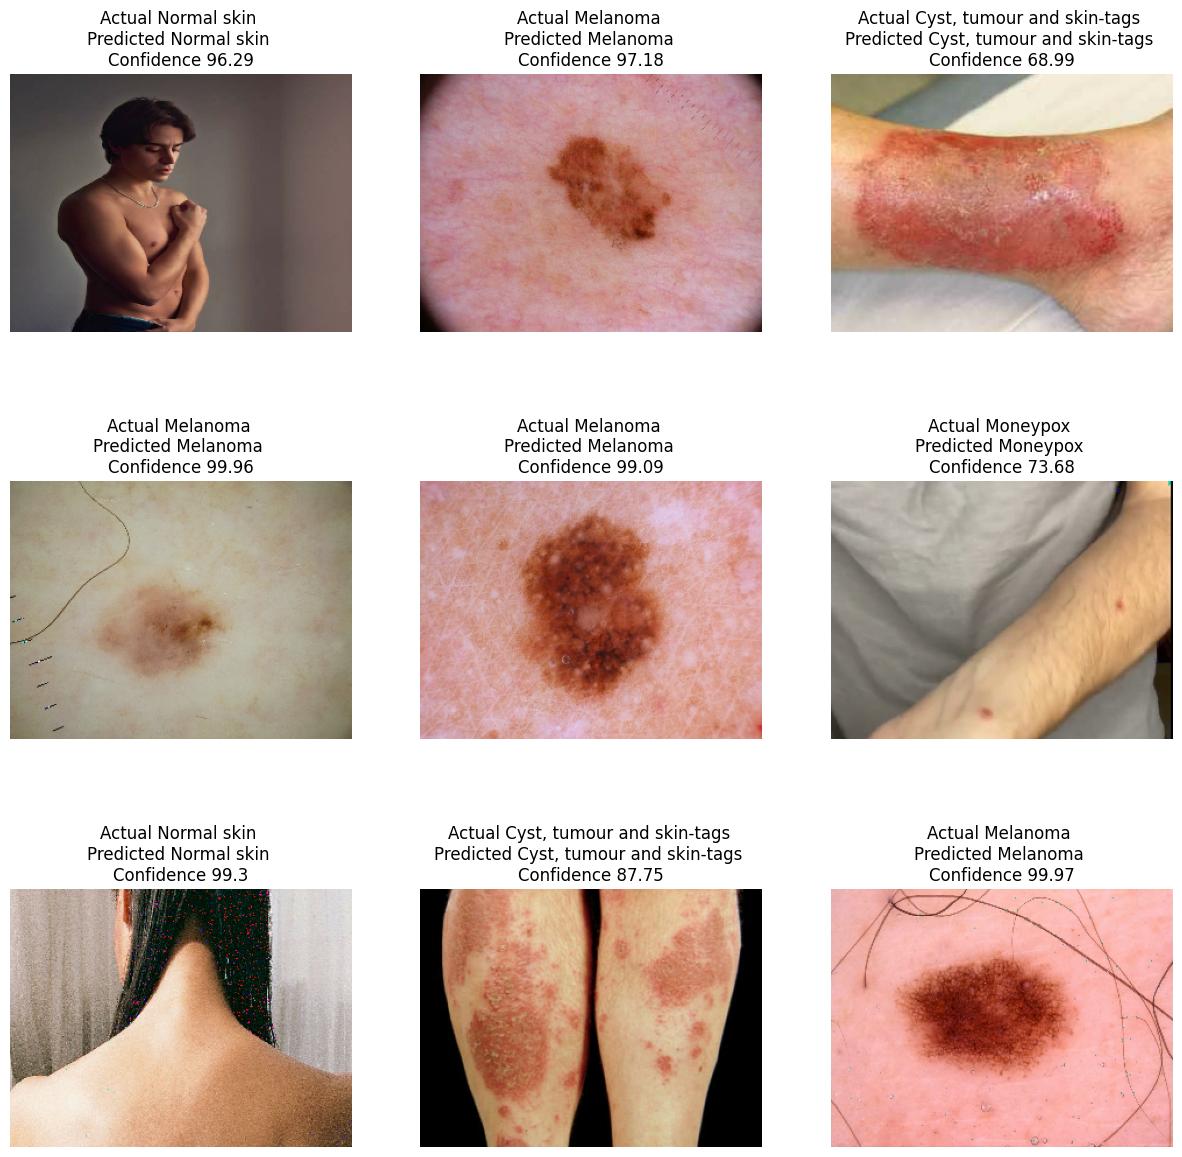

In [23]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual {actual_class} \nPredicted {predicted_class} \nConfidence {confidence}')
        plt.axis('off')